# Reservoir Evaporation API Tutorial

This notebook provides a comprehensive guide to working with the Reservoir Evaporation API. We'll walk through retrieving, analyzing, and visualizing reservoir evaporation data.

By the end of this tutorial, you'll be able to:
- Setup and configure the API connection
- Retrieve reservoir data and metadata
- Analyze evaporation patterns for individual and multiple reservoirs
- Combine weather and evaporation data for analysis
- Visualize evaporation trends

## Setup

To get Setup add **api_key** to the colab secrets and add your overevap api key as value

1. Open your Google Colab notebook and click on the `secrets` tab.
2. Create a new secret with the name `api_key`.
3. Paste your api key into the `Value` input box of the created secret.
4. Toggle the button on the left to allow notebook access to the secret.

![image](https://picsur.spatialbytes.work/i/be499c55-0a8d-49e8-9cb8-15977b528133.gif)

## Installation

Since we're running in Google Colab, we don't need a virtual environment. Instead, we'll use `uv` for fast package installation.

In [3]:
# Install uv for faster package installation
!pip install uv -q

# Install required packages using uv
!uv pip install geopandas matplotlib pandas requests seaborn -q

from google.colab import userdata
API_KEY=userdata.get('api_key')

## Setting up the API Connection

Now we'll configure our API connection. You'll need to replace the placeholder API key with your actual key to make the API calls work.

In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from datetime import datetime

BASE_URL = "https://operevap.dri.edu/"  # Base URL for the API
HEADERS = {
    "api-key": API_KEY
}

# Set some visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
print("API connection configured successfully!")

API connection configured successfully!


## Getting Available Reservoirs

Our first API request will retrieve a list of all available reservoirs in the database. This helps us understand what data is available and which reservoirs we can analyze.

In [5]:
def get_reservoirs():
    """Get a list of available reservoirs."""
    url = f"{BASE_URL}/info/list_RES_NAMES"
    response = requests.post(url, headers=HEADERS)

    if response.status_code == 200 and "RES_NAMES" in response.json().keys():
        return response.json()["RES_NAMES"]
    else:
        print(f"Error: {response.status_code}")
        return None

# Example usage
reservoirs = get_reservoirs()
if reservoirs:
    print(f"Number of reservoirs: {len(reservoirs)}")
    print("\nFirst 10 reservoirs:")
    for res in reservoirs[:10]:
        print(f"- {res}")

Number of reservoirs: 247

First 10 reservoirs:
- ABIQUIU LAKE
- AGATE RESERVOIR
- ALCOVA RESERVOIR
- AMERICAN FALLS RESERVOIR
- ANCHOR RESERVOIR
- ANDERSON RANCH RESERVOIR
- ANGOSTURA RESERVOIR
- ANITA RESERVOIR
- APACHE LAKE
- ARROWROCK RESERVOIR


## Getting Reservoir Metadata

Now that we know which reservoirs are available, let's retrieve detailed metadata for specific reservoirs of interest. This metadata includes geographical information like latitude, longitude, and area.

In [6]:
def get_reservoir_metadata(reservoir_names):
    """Get metadata for specified reservoirs."""
    url = f"{BASE_URL}/metadata/reservoirs"
    params = {
        "RES_NAMES": ",".join(reservoir_names) if isinstance(reservoir_names, list) else reservoir_names,
        "output_format": "json"
    }

    response = requests.get(url, headers=HEADERS, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None

# Example usage with two reservoirs
sample_reservoirs = ["LAKE ALICE", "LAKE ESTES"]
reservoir_metadata = get_reservoir_metadata(sample_reservoirs)

if reservoir_metadata:
    print("\n--- Reservoir Metadata ---")
    for res in reservoir_metadata:
        print(f"\nReservoir: {res['RES_NAME']}")
        print(f"  Latitude: {res['LAT']}")
        print(f"  Longitude: {res['LON']}")
        print(f"  Area: {res['Shape_Area']} square units")


--- Reservoir Metadata ---

Reservoir: LAKE ALICE
  Latitude: 41.98899071476591
  Longitude: -103.6136586653595
  Area: 4557804.08841 square units

Reservoir: LAKE ESTES
  Latitude: 40.37640029041887
  Longitude: -105.49650035090777
  Area: 964971.978541 square units


## Retrieving Time Series Data

Now we'll get evaporation data for a specific reservoir over a defined time period. This data includes daily net evaporation values and evaporation volumes.

In [7]:
def get_reservoir_timeseries(reservoir_name, start_date, end_date):
    """Get timeseries data for a reservoir."""
    url = f"{BASE_URL}/timeseries/daily/reservoirs/daterange"
    params = {
        "RES_NAMES": reservoir_name,
        "datasets": "nete-volume-calcs",
        "variables": "NetE,E_volume",
        "start_date": start_date,
        "end_date": end_date,
        "units": "metric",
        "output_format": "json"
    }

    response = requests.get(url, headers=HEADERS, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None

# Example usage
reservoir_name = "LAKE ALICE"
start_date = "2020-01-01"
end_date = "2020-12-31"
data = get_reservoir_timeseries(reservoir_name, start_date, end_date)

if data:
    # Convert to pandas DataFrame for analysis
    df = pd.DataFrame(data)
    df['start_date'] = pd.to_datetime(df['start_date'])
    df.set_index('start_date', inplace=True)

    # Display the first few rows
    print("\n--- Sample Evaporation Data ---")
    print(df.head())


--- Sample Evaporation Data ---
              RES_NAME    end_date  NetE (mm)  E_volume (m3)
start_date                                                  
2020-01-01  LAKE ALICE  2020-01-01     0.8182      2490.0388
2020-01-02  LAKE ALICE  2020-01-02     0.4154      1264.2883
2020-01-03  LAKE ALICE  2020-01-03     0.3425      1042.2593
2020-01-04  LAKE ALICE  2020-01-04     0.6796      2068.1335
2020-01-05  LAKE ALICE  2020-01-05     1.1349      3453.6785


Let's visualize this time series data to better understand the evaporation patterns over the year.

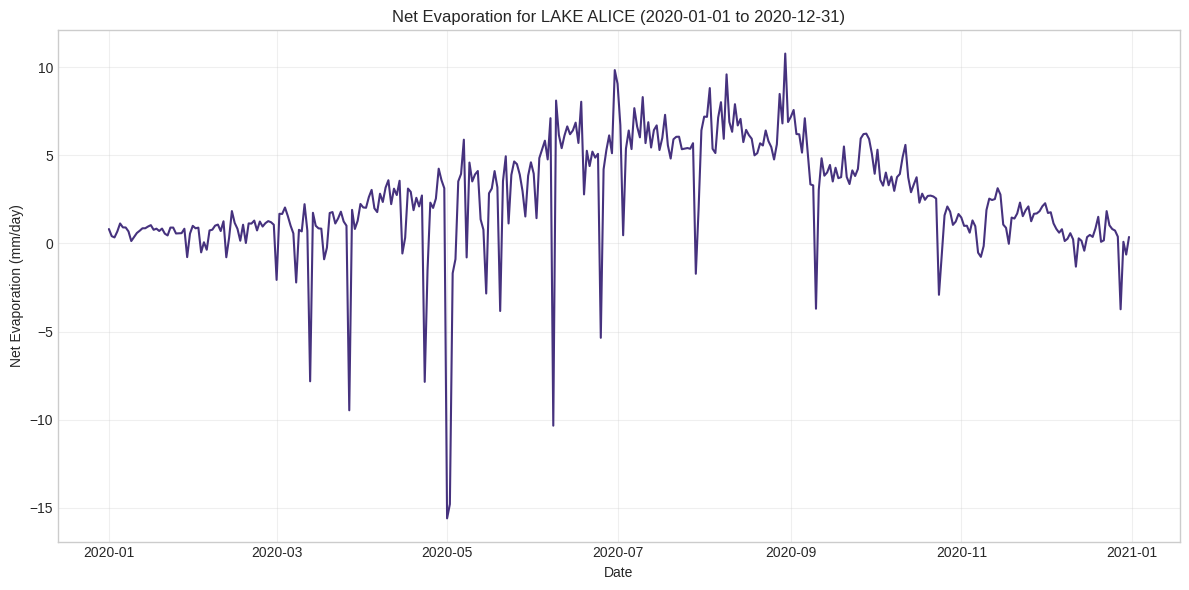

In [8]:
if 'df' in locals() and not df.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['NetE (mm)'], linewidth=1.5)
    plt.title(f'Net Evaporation for {reservoir_name} ({start_date} to {end_date})')
    plt.xlabel('Date')
    plt.ylabel('Net Evaporation (mm/day)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Comparing Evaporation Between Multiple Reservoirs

Now let's compare evaporation rates across multiple reservoirs for the same time period. This helps us understand regional variations and identify patterns.

In [9]:
def compare_reservoirs(reservoir_names, start_date, end_date, variable="NetE"):
    """Compare a variable between multiple reservoirs."""
    url = f"{BASE_URL}/timeseries/daily/reservoirs/daterange"
    params = {
        "RES_NAMES": ",".join(reservoir_names) if isinstance(reservoir_names, list) else reservoir_names,
        "datasets": "nete-volume-calcs",
        "variables": variable,
        "start_date": start_date,
        "end_date": end_date,
        "units": "metric",
        "output_format": "json"
    }

    response = requests.get(url, headers=HEADERS, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None

# Example usage - Comparing summer evaporation rates for three reservoirs
reservoirs_to_compare = ["LAKE ALICE", "LAKE ESTES", "RUEDI RESERVOIR"]
summer_start = "2020-06-01"
summer_end = "2020-08-31"
comparison_data = compare_reservoirs(reservoirs_to_compare, summer_start, summer_end)

Now let's process this data and create a visualization to compare the evaporation rates across these reservoirs.

<ipython-input-10-e91dc6c3f82f>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_df = pivot_df.fillna(method='ffill')


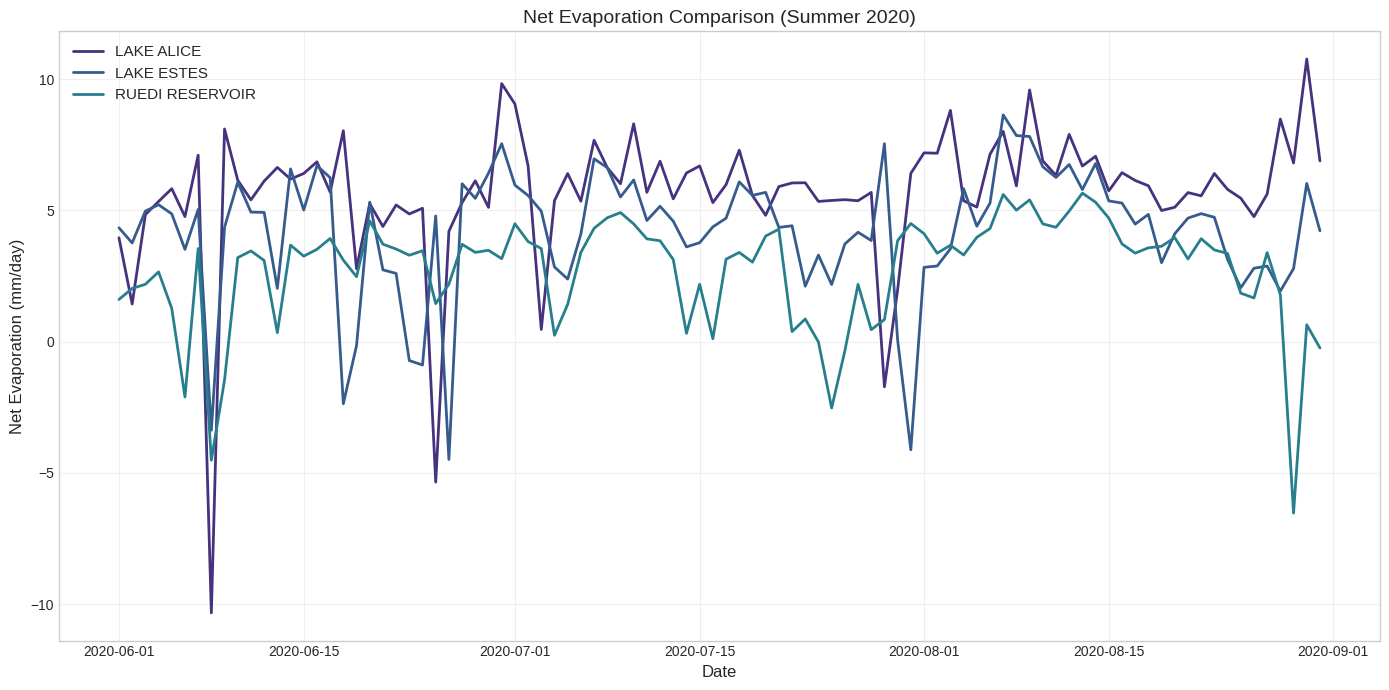


--- Evaporation Statistics Summary (Summer 2020) ---
                     mean      min      max       std
RES_NAME                                             
LAKE ALICE       5.666762 -10.3357  10.7721  2.703804
LAKE ESTES       4.207512  -4.4878   8.6443  2.468489
RUEDI RESERVOIR  2.732351  -6.5305   5.6617  2.099909


In [10]:
if comparison_data:
    # Process and visualize data
    df = pd.DataFrame(comparison_data)
    df['start_date'] = pd.to_datetime(df['start_date'])

    # Pivot the data to have one column per reservoir
    pivot_df = df.pivot_table(index='start_date', columns='RES_NAME', values='NetE (mm)')

    # Fill NaN values for cleaner visualization
    pivot_df = pivot_df.fillna(method='ffill')

    # Plot the data
    plt.figure(figsize=(14, 7))
    for reservoir in reservoirs_to_compare:
        plt.plot(pivot_df.index, pivot_df[reservoir], label=reservoir, linewidth=2)

    plt.title('Net Evaporation Comparison (Summer 2020)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Net Evaporation (mm/day)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Create a summary statistics table
    summary = pivot_df.describe().T.sort_values(by='mean', ascending=False)
    print("\n--- Evaporation Statistics Summary (Summer 2020) ---")
    print(summary[['mean', 'min', 'max', 'std']])

## Calculating Monthly Evaporation Volumes

Next, let's analyze monthly evaporation volumes for a specific reservoir. This is particularly useful for water resource management and planning.

In [12]:
def get_monthly_evaporation_volumes(reservoir_name, year):
    """Calculate monthly evaporation volumes for a reservoir."""
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    url = f"{BASE_URL}/timeseries/daily/reservoirs/daterange"
    params = {
        "RES_NAMES": reservoir_name,
        "datasets": "nete-volume-calcs",
        "variables": "E_volume",
        "start_date": start_date,
        "end_date": end_date,
        "units": "metric",
        "output_format": "json"
    }

    response = requests.get(url, headers=HEADERS, params=params)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data)
        df['start_date'] = pd.to_datetime(df['start_date'])
        df.set_index('start_date', inplace=True)

        # Calculate monthly totals
        monthly_data = df.resample('ME').sum()
        monthly_data.index = monthly_data.index.strftime('%b')

        return monthly_data
    else:
        print(f"Error: {response.status_code}")
        return None

# Example usage
reservoir_name = "LAKE MEAD"
year = 2020
monthly_volumes = get_monthly_evaporation_volumes(reservoir_name, year)

Let's visualize these monthly evaporation volumes to better understand seasonal patterns.

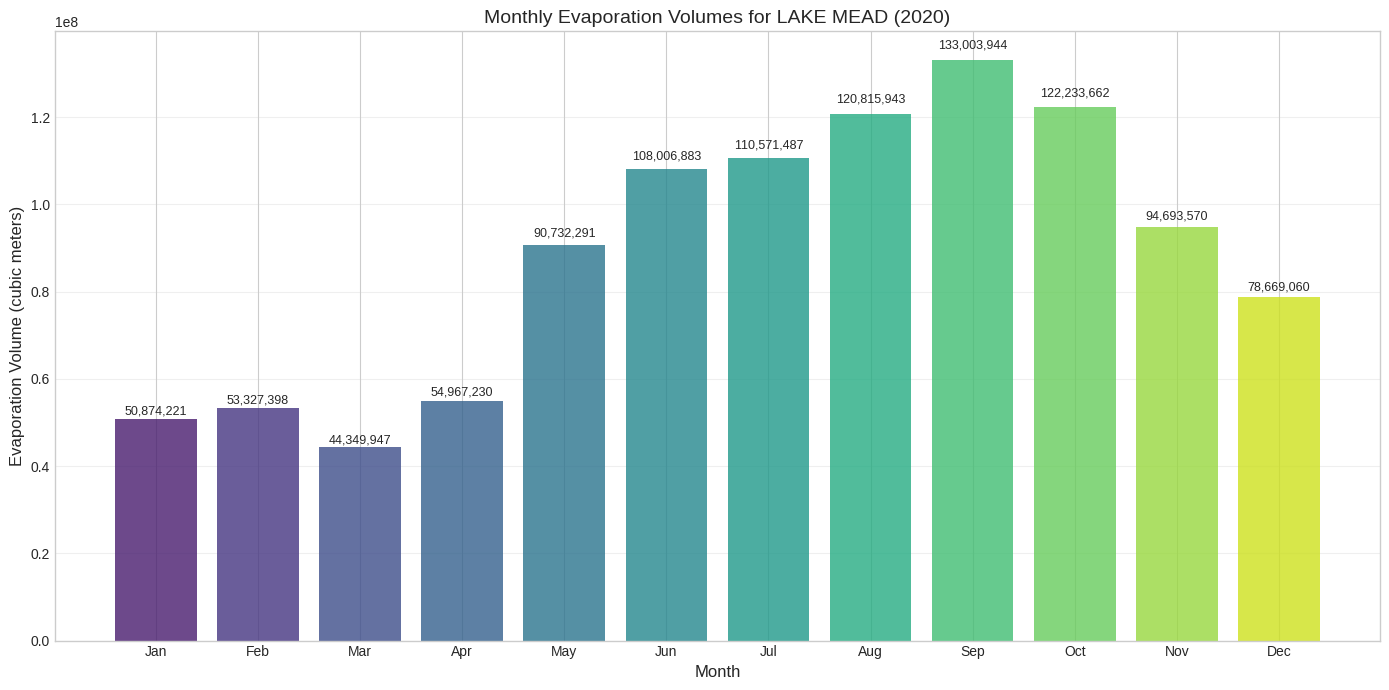


Total annual evaporation volume for LAKE MEAD in 2020: 1,062,245,636 cubic meters


In [13]:
if monthly_volumes is not None:
    # Plot monthly volumes with a nicer style
    plt.figure(figsize=(14, 7))
    ax = plt.bar(monthly_volumes.index, monthly_volumes['E_volume (m3)'],
                color=sns.color_palette("viridis", 12), alpha=0.8)

    # Add value labels on top of each bar
    for i, v in enumerate(monthly_volumes['E_volume (m3)']):
        plt.text(i, v + v*0.02, f'{v:,.0f}', ha='center', fontsize=9)

    plt.title(f'Monthly Evaporation Volumes for {reservoir_name} ({year})', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Evaporation Volume (cubic meters)', fontsize=12)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate and display total annual evaporation
    annual_total = monthly_volumes['E_volume (m3)'].sum()
    print(f"\nTotal annual evaporation volume for {reservoir_name} in {year}: {annual_total:,.0f} cubic meters")

## Retrieving and Analyzing Weather Data

Evaporation is closely related to weather conditions. Let's retrieve weather data for a reservoir and analyze how it relates to evaporation rates.

In [14]:
def get_weather_data(reservoir_name, start_date, end_date):
    """Get weather data for a reservoir."""
    url = f"{BASE_URL}/timeseries/daily/reservoirs/daterange"
    params = {
        "RES_NAMES": reservoir_name,
        "datasets": "rtma",
        "variables": "pr,tmmx_c,tmmn_c,vpd_kpa,srad",
        "start_date": start_date,
        "end_date": end_date,
        "units": "metric",
        "output_format": "json"
    }

    response = requests.get(url, headers=HEADERS, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None

# Example usage
reservoir_name = "LAKE POWELL"
start_date = "2020-06-01"
end_date = "2020-08-31"
weather_data = get_weather_data(reservoir_name, start_date, end_date)

if weather_data:
    df = pd.DataFrame(weather_data)
    df['start_date'] = pd.to_datetime(df['start_date'])
    df.set_index('start_date', inplace=True)

    # Display the first few rows
    print("\n--- Sample Weather Data ---")
    print(df.head())


--- Sample Weather Data ---
               RES_NAME    end_date  pr (mm)  tmmx_c (degC)  tmmn_c (degC)  \
start_date                                                                   
2020-06-01  LAKE POWELL  2020-06-01   0.0000        33.8065        18.9577   
2020-06-02  LAKE POWELL  2020-06-02   0.0000        34.3777        17.6963   
2020-06-03  LAKE POWELL  2020-06-03   0.0000        34.3294        18.6891   
2020-06-04  LAKE POWELL  2020-06-04   0.0000        35.4096        18.5226   
2020-06-05  LAKE POWELL  2020-06-05   1.9885        34.8213        18.8904   

            vpd_kpa (kpa)  srad (wm2)  
start_date                             
2020-06-01         3.0989    336.0240  
2020-06-02         3.0882    302.6131  
2020-06-03         3.1585    205.7495  
2020-06-04         3.3079    344.9900  
2020-06-05         3.1739    322.9861  


Now let's calculate monthly weather averages and create a visualization of temperature and precipitation data.

<ipython-input-15-04d14515efdc>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_weather = df.resample('M').agg({



--- Monthly Weather Summary for LAKE POWELL (Summer 2020) ---
            Total Precipitation (mm)  Avg Max Temp (°C)  Avg Min Temp (°C)  \
start_date                                                                   
2020-06-30                   3.8e+00               32.5               17.9   
2020-07-31                   1.4e+01               35.7               21.2   
2020-08-31                   8.8e-02               36.6               21.5   

            Avg Vapor Pressure Deficit (kPa)  Avg Solar Radiation (W/m²)  
start_date                                                                
2020-06-30                               3.0                       332.8  
2020-07-31                               3.3                       306.7  
2020-08-31                               3.6                       266.6  


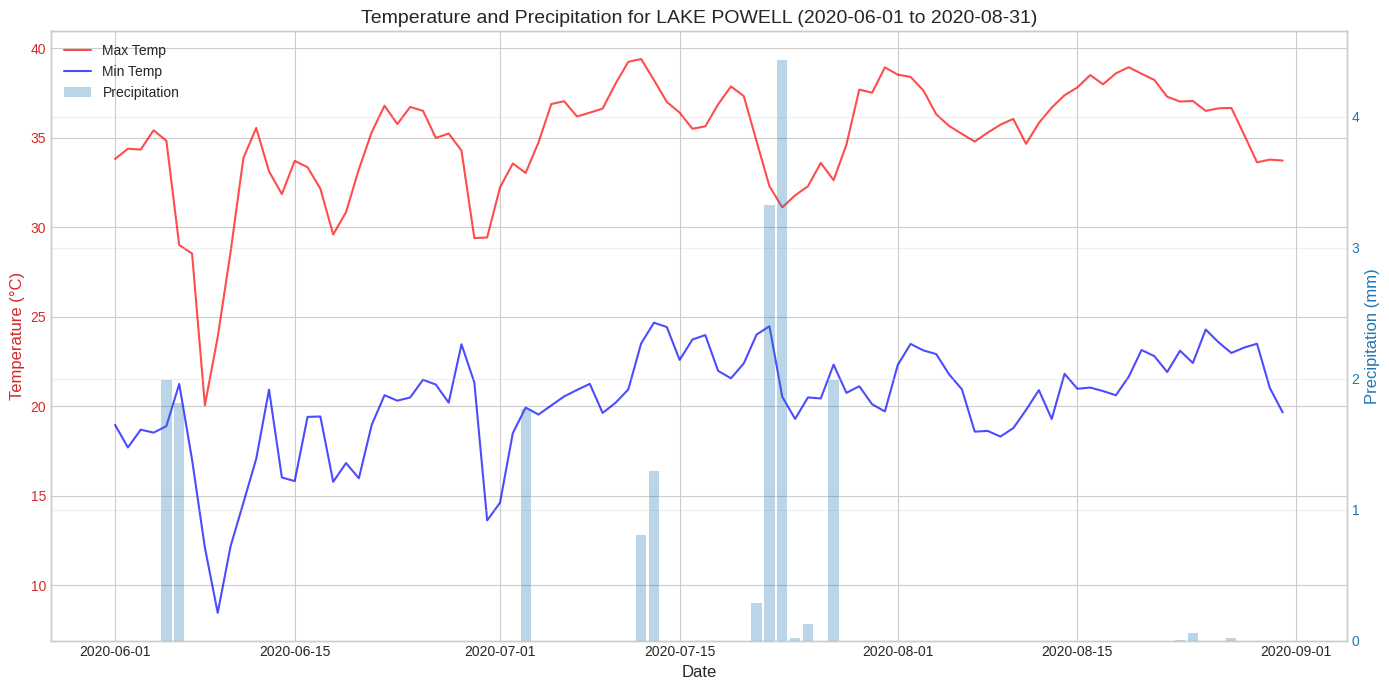

In [15]:
if 'df' in locals() and not df.empty:
    # Calculate monthly averages
    monthly_weather = df.resample('M').agg({
        'pr (mm)': 'sum',
        'tmmx_c (degC)': 'mean',
        'tmmn_c (degC)': 'mean',
        'vpd_kpa (kpa)': 'mean',
        'srad (wm2)': 'mean'
    })

    # Make column names more readable for display
    readable_cols = {
        'pr (mm)': 'Total Precipitation (mm)',
        'tmmx_c (degC)': 'Avg Max Temp (°C)',
        'tmmn_c (degC)': 'Avg Min Temp (°C)',
        'vpd_kpa (kpa)': 'Avg Vapor Pressure Deficit (kPa)',
        'srad (wm2)': 'Avg Solar Radiation (W/m²)'
    }
    monthly_weather.rename(columns=readable_cols, inplace=True)

    print("\n--- Monthly Weather Summary for LAKE POWELL (Summer 2020) ---")
    pd.set_option('display.precision', 1)
    print(monthly_weather)

    # Create visualization of temperature and precipitation
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot temperature data on primary y-axis
    color = 'tab:red'
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Temperature (°C)', color=color, fontsize=12)
    ax1.plot(df.index, df['tmmx_c (degC)'], color='red', alpha=0.7, label='Max Temp')
    ax1.plot(df.index, df['tmmn_c (degC)'], color='blue', alpha=0.7, label='Min Temp')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for precipitation
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Precipitation (mm)', color=color, fontsize=12)
    ax2.bar(df.index, df['pr (mm)'], color=color, alpha=0.3, label='Precipitation')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Temperature and Precipitation for {reservoir_name} ({start_date} to {end_date})', fontsize=14)

    # Create a combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Combining Evaporation and Weather Data for Analysis

Now let's combine evaporation and weather data to analyze relationships between climate variables and evaporation rates.

In [16]:
def combine_datasets(reservoir_name, start_date, end_date):
    """Combine evaporation and weather data for analysis."""
    # Get evaporation data
    evap_url = f"{BASE_URL}/timeseries/daily/reservoirs/daterange"
    evap_params = {
        "RES_NAMES": reservoir_name,
        "datasets": "nete-volume-calcs",
        "variables": "NetE,E_volume",
        "start_date": start_date,
        "end_date": end_date,
        "units": "metric",
        "output_format": "json"
    }

    evap_response = requests.get(evap_url, headers=HEADERS, params=evap_params)

    # Get weather data
    weather_url = f"{BASE_URL}/timeseries/daily/reservoirs/daterange"
    weather_params = {
        "RES_NAMES": reservoir_name,
        "datasets": "rtma",
        "variables": "pr,tmmx_c,tmmn_c,vpd_kpa,srad",
        "start_date": start_date,
        "end_date": end_date,
        "units": "metric",
        "output_format": "json"
    }

    weather_response = requests.get(weather_url, headers=HEADERS, params=weather_params)

    if evap_response.status_code == 200 and weather_response.status_code == 200:
        evap_data = pd.DataFrame(evap_response.json())
        weather_data = pd.DataFrame(weather_response.json())

        # Prepare data
        evap_data['start_date'] = pd.to_datetime(evap_data['start_date'])
        evap_data.set_index(['start_date', 'RES_NAME'], inplace=True)

        weather_data['start_date'] = pd.to_datetime(weather_data['start_date'])
        weather_data.set_index(['start_date', 'RES_NAME'], inplace=True)

        # Merge datasets
        combined_data = pd.merge(evap_data, weather_data, left_index=True, right_index=True)

        return combined_data
    else:
        print(f"Error: {evap_response.status_code} or {weather_response.status_code}")
        return None

# Example usage
reservoir_name = "LAKE MEAD"
start_date = "2020-06-01"
end_date = "2020-08-31"
combined_data = combine_datasets(reservoir_name, start_date, end_date)

if combined_data is not None:
    combined_data.reset_index(inplace=True)

    # Display the first few rows of the combined dataset
    print("\n--- Combined Evaporation and Weather Data ---")
    print(combined_data.head())


--- Combined Evaporation and Weather Data ---
  start_date   RES_NAME  end_date_x  NetE (mm)  E_volume (m3)  end_date_y  \
0 2020-06-01  LAKE MEAD  2020-06-01        4.7        3.0e+06  2020-06-01   
1 2020-06-02  LAKE MEAD  2020-06-02        3.7        2.4e+06  2020-06-02   
2 2020-06-03  LAKE MEAD  2020-06-03        3.2        2.0e+06  2020-06-03   
3 2020-06-04  LAKE MEAD  2020-06-04        4.4        2.8e+06  2020-06-04   
4 2020-06-05  LAKE MEAD  2020-06-05        4.9        3.1e+06  2020-06-05   

   pr (mm)  tmmx_c (degC)  tmmn_c (degC)  vpd_kpa (kpa)  srad (wm2)  
0      0.0           35.1           22.6            3.4       338.3  
1      0.0           35.9           23.9            3.5       312.5  
2      0.0           37.2           25.5            3.8       279.5  
3      0.0           38.2           25.1            4.0       339.6  
4      0.0           37.0           27.1            4.0       280.1  


Now let's analyze correlations between weather variables and evaporation rates, and visualize these relationships.


--- Correlation Matrix ---
               NetE (mm)  tmmx_c (degC)  tmmn_c (degC)  vpd_kpa (kpa)  \
NetE (mm)        1.0e+00       -3.2e-01       -9.9e-02       -1.6e-01   
tmmx_c (degC)   -3.2e-01        1.0e+00        7.7e-01        9.4e-01   
tmmn_c (degC)   -9.9e-02        7.7e-01        1.0e+00        7.6e-01   
vpd_kpa (kpa)   -1.6e-01        9.4e-01        7.6e-01        1.0e+00   
srad (wm2)       1.7e-01       -4.5e-01       -5.0e-01       -3.5e-01   
pr (mm)          3.1e-03       -5.5e-02        1.2e-01       -8.3e-02   

               srad (wm2)  pr (mm)  
NetE (mm)         1.7e-01  3.1e-03  
tmmx_c (degC)    -4.5e-01 -5.5e-02  
tmmn_c (degC)    -5.0e-01  1.2e-01  
vpd_kpa (kpa)    -3.5e-01 -8.3e-02  
srad (wm2)        1.0e+00  3.1e-02  
pr (mm)           3.1e-02  1.0e+00  


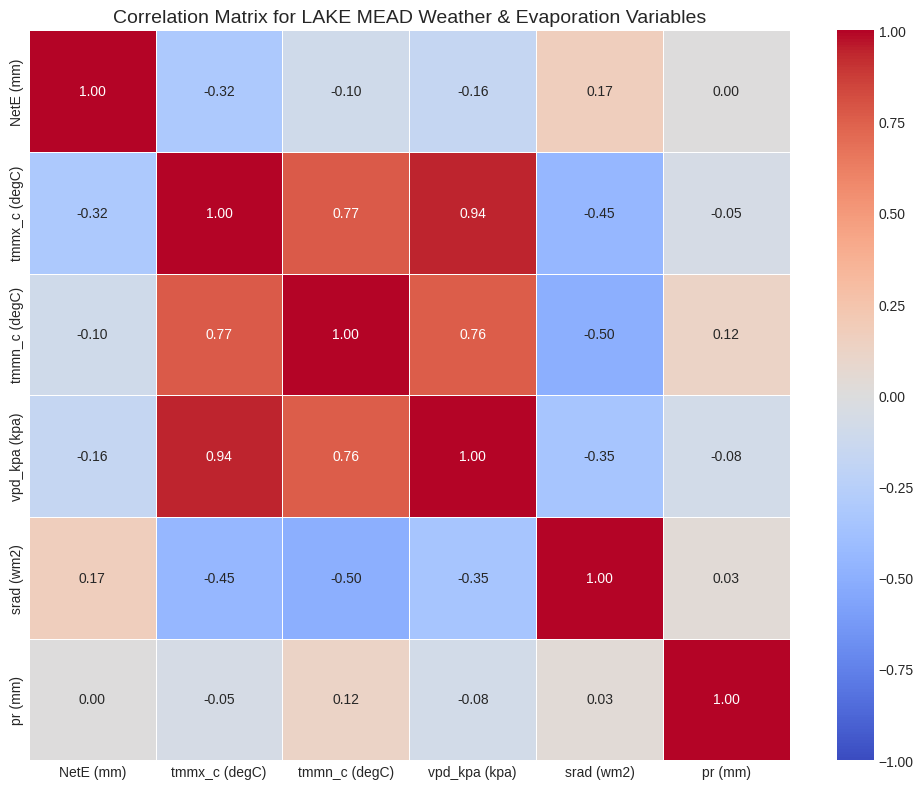

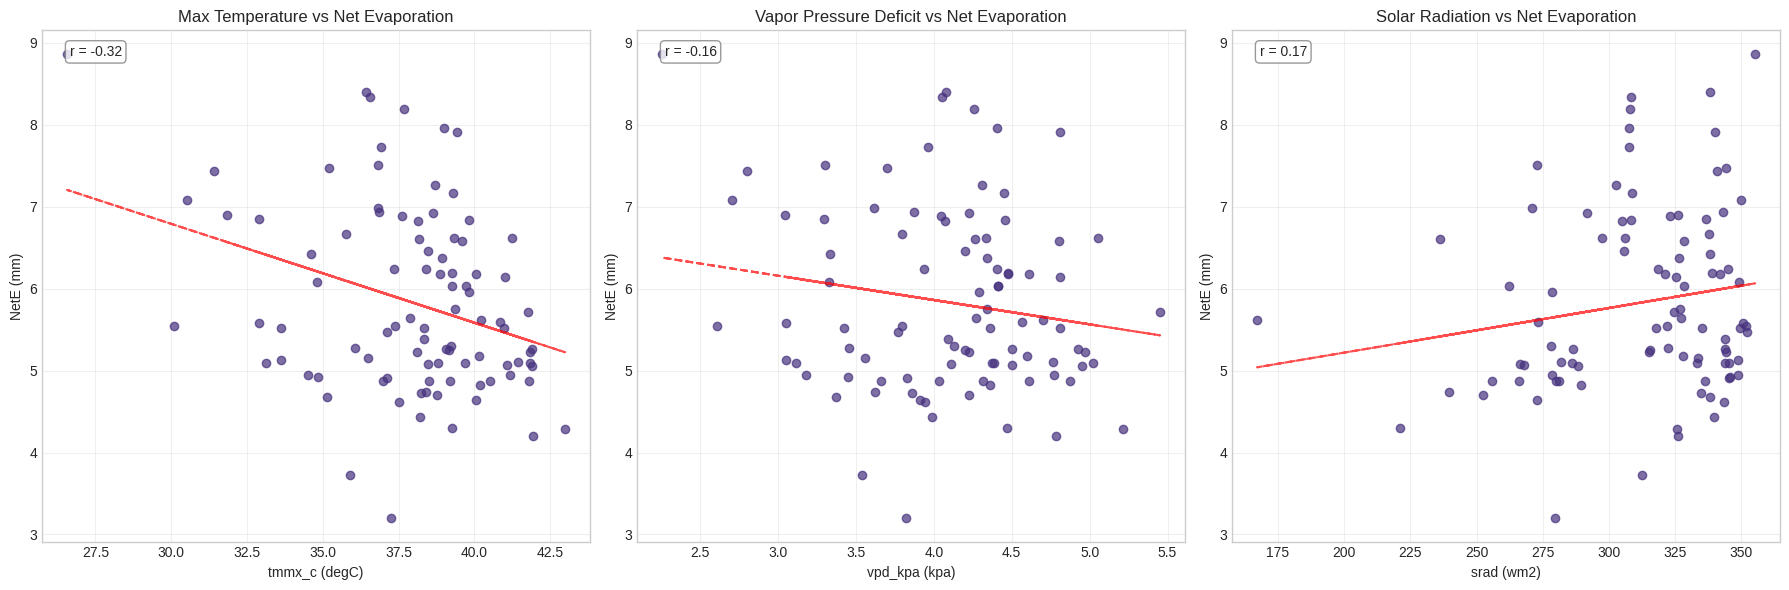

In [17]:
if 'combined_data' in locals() and combined_data is not None:
    # Calculate correlation between variables
    correlation_vars = ['NetE (mm)', 'tmmx_c (degC)', 'tmmn_c (degC)', 'vpd_kpa (kpa)', 'srad (wm2)', 'pr (mm)']
    correlation = combined_data[correlation_vars].corr()

    print("\n--- Correlation Matrix ---")
    print(correlation)

    # Visualize correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix for {reservoir_name} Weather & Evaporation Variables', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Create scatter plots to visualize relationships
    variables_to_compare = [
        ('tmmx_c (degC)', 'NetE (mm)', 'Max Temperature vs Net Evaporation'),
        ('vpd_kpa (kpa)', 'NetE (mm)', 'Vapor Pressure Deficit vs Net Evaporation'),
        ('srad (wm2)', 'NetE (mm)', 'Solar Radiation vs Net Evaporation')
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (x_var, y_var, title) in enumerate(variables_to_compare):
        axes[i].scatter(combined_data[x_var], combined_data[y_var], alpha=0.7)
        axes[i].set_xlabel(x_var, fontsize=10)
        axes[i].set_ylabel(y_var, fontsize=10)
        axes[i].set_title(title, fontsize=12)
        axes[i].grid(True, alpha=0.3)

        # Add regression line
        z = np.polyfit(combined_data[x_var], combined_data[y_var], 1)
        p = np.poly1d(z)
        axes[i].plot(combined_data[x_var], p(combined_data[x_var]), "r--", alpha=0.7)

        # Add correlation coefficient to the plot
        corr_coef = combined_data[x_var].corr(combined_data[y_var])
        axes[i].annotate(f'r = {corr_coef:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                        fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.tight_layout()
    plt.show()

## Data Export Functionality

Finally, let's create a function to export data for multiple reservoirs to a CSV file for further analysis in other tools.

In [18]:
def export_data_to_csv(reservoir_names, start_date, end_date, output_file):
    """Export data for multiple reservoirs to CSV."""
    url = f"{BASE_URL}/timeseries/daily/reservoirs/daterange"
    params = {
        "RES_NAMES": ",".join(reservoir_names) if isinstance(reservoir_names, list) else reservoir_names,
        "datasets": "nete-volume-calcs",
        "variables": "NetE,E_volume",
        "start_date": start_date,
        "end_date": end_date,
        "units": "metric",
        "output_format": "json"
    }

    response = requests.get(url, headers=HEADERS, params=params)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data)
        df.to_csv(output_file, index=False)
        print(f"Data exported to {output_file}")
        return True
    else:
        print(f"Error: {response.status_code}")
        return False

# Example usage
reservoir_list = ["LAKE POWELL", "LAKE MEAD", "FLAMING GORGE RESERVOIR"]
output_file = "colorado_river_basin_evaporation_2020.csv"
export_data_to_csv(reservoir_list, "2020-01-01", "2020-12-31", output_file)

# Let's preview the first few rows of the exported file
try:
    exported_data = pd.read_csv(output_file)
    print("\n--- Preview of Exported Data ---")
    print(exported_data.head())
except:
    print("\nUnable to read the exported file (this is expected in Colab as files are saved in the runtime environment)")

Data exported to colorado_river_basin_evaporation_2020.csv

--- Preview of Exported Data ---
                  RES_NAME  start_date    end_date  NetE (mm)  E_volume (m3)
0  FLAMING GORGE RESERVOIR  2020-01-01  2020-01-01        2.2       343979.7
1  FLAMING GORGE RESERVOIR  2020-01-02  2020-01-02        2.6       405138.1
2  FLAMING GORGE RESERVOIR  2020-01-03  2020-01-03        2.0       310664.7
3  FLAMING GORGE RESERVOIR  2020-01-04  2020-01-04        1.9       301476.1
4  FLAMING GORGE RESERVOIR  2020-01-05  2020-01-05        1.9       287876.1


## Conclusion

In this notebook, we've explored how to use the Reservoir Evaporation API to:

1. Retrieve reservoir information and metadata
2. Get evaporation and weather data for specific reservoirs and time periods
3. Analyze and visualize evaporation patterns
4. Compare evaporation across multiple reservoirs
5. Investigate relationships between weather variables and evaporation rates
6. Export data for further analysis

This provides a foundation for water resource management, research, and planning activities. You can extend these examples to create more complex analyses tailored to your specific needs.

Remember to replace `"your_api_key_here"` with your actual API key when using this notebook.